In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from itertools import islice, cycle, product
from tqdm import tqdm_notebook
from ast import literal_eval

In [2]:
df1=pd.read_csv("anime.csv") 
df2=pd.read_csv("anime_with_synopsis.csv")

In [3]:
metadata=pd.merge(df1,df2[['MAL_ID','sypnopsis']],on='MAL_ID',how='left')

In [4]:
metadata.head(3)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,"Vash the Stampede is the man with a $$60,000,0..."


In [5]:
metadata.rename(columns={
    'MAL_ID': 'anime_id',
    'Name': 'title',
    'English name': 'english_name',
    'Japanese name': 'japanese_name',
    'Type': 'type',
    'Episodes': 'episodes',
    'Status': 'status',
    'Aired': 'aired',
    'Premiered': 'premiered',
    'Studios': 'studios',
    'Source': 'source',
    'Duration': 'duration',
    'Rating': 'rating',
    'Ranked': 'ranked',
    'Popularity': 'popularity',
    'Members': 'members',
    'Favorites': 'favorites',
    'Genres': 'genres',
    'Themes': 'themes',
    'Demographic': 'demographic',
    'Year': 'year',
    'Score': 'score',
    'Licensors': 'licensors',
    'Watching': 'watching',
    'completed': 'completed',
    'On-Hold':'on_hold',
    'Dropped': 'dropped',
    'Plan to Watch': 'plan_to_watch',
    'Score-10': 'score_10',
    'Score-9': 'score_9',
    'Score-8': 'score_8',
    'Score-7': 'score_7',
    'Score-6': 'score_6',
    'Score-5': 'score_5',
    'Score-4': 'score_4',
    'Score-3': 'score_3',
    'Score-2': 'score_2',
    'Score-1': 'score_1',
    'sypnopsis': 'description',
}, inplace=True)

In [6]:
metadata.head(3)

,anime_id,title,score,genres,english_name,japanese_name,type,episodes,aired,premiered,...,score_9,score_8,score_7,score_6,score_5,score_4,score_3,score_2,score_1,description
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,"Vash the Stampede is the man with a $$60,000,0..."


In [7]:
c=0
for i in metadata.english_name:
    if i == 'Unknown':
        c+=1
print(c)

10565


In [8]:
metadata.loc[metadata['english_name'] == 'Unknown', 'english_name'] = metadata['title']

## Explanatory Analysis

In [9]:
metadata.describe().T

,count,mean,std,min,25%,50%,75%,max
anime_id,17562.0,21477.192347,14900.093170,1.0,5953.5,22820.0,35624.75,48492.0
popularity,17562.0,8763.452340,5059.327278,0.0,4383.5,8762.5,13145.00,17565.0
members,17562.0,34658.539517,125282.141428,1.0,336.0,2065.0,13223.25,2589552.0
favorites,17562.0,457.746270,4063.473313,0.0,0.0,3.0,31.00,183914.0
watching,17562.0,2231.487758,14046.688133,0.0,13.0,73.0,522.00,887333.0
Completed,17562.0,22095.571347,91009.188504,0.0,111.0,817.5,6478.00,2182587.0
on_hold,17562.0,955.049653,4275.675096,0.0,6.0,45.0,291.75,187919.0
dropped,17562.0,1176.599533,4740.348653,0.0,37.0,77.0,271.00,174710.0
plan_to_watch,17562.0,8199.831227,23777.691963,1.0,112.0,752.5,4135.50,425531.0


In [23]:
wordcloud_genre=WordCloud(width=1500,height=800,background_color='black',min_font_size=2
                    ,min_word_length=3).generate(genres)
wordcloud_title=WordCloud(width=1500,height=800,background_color='cyan',min_font_size=2
                    ,min_word_length=3).generate(anime_title)

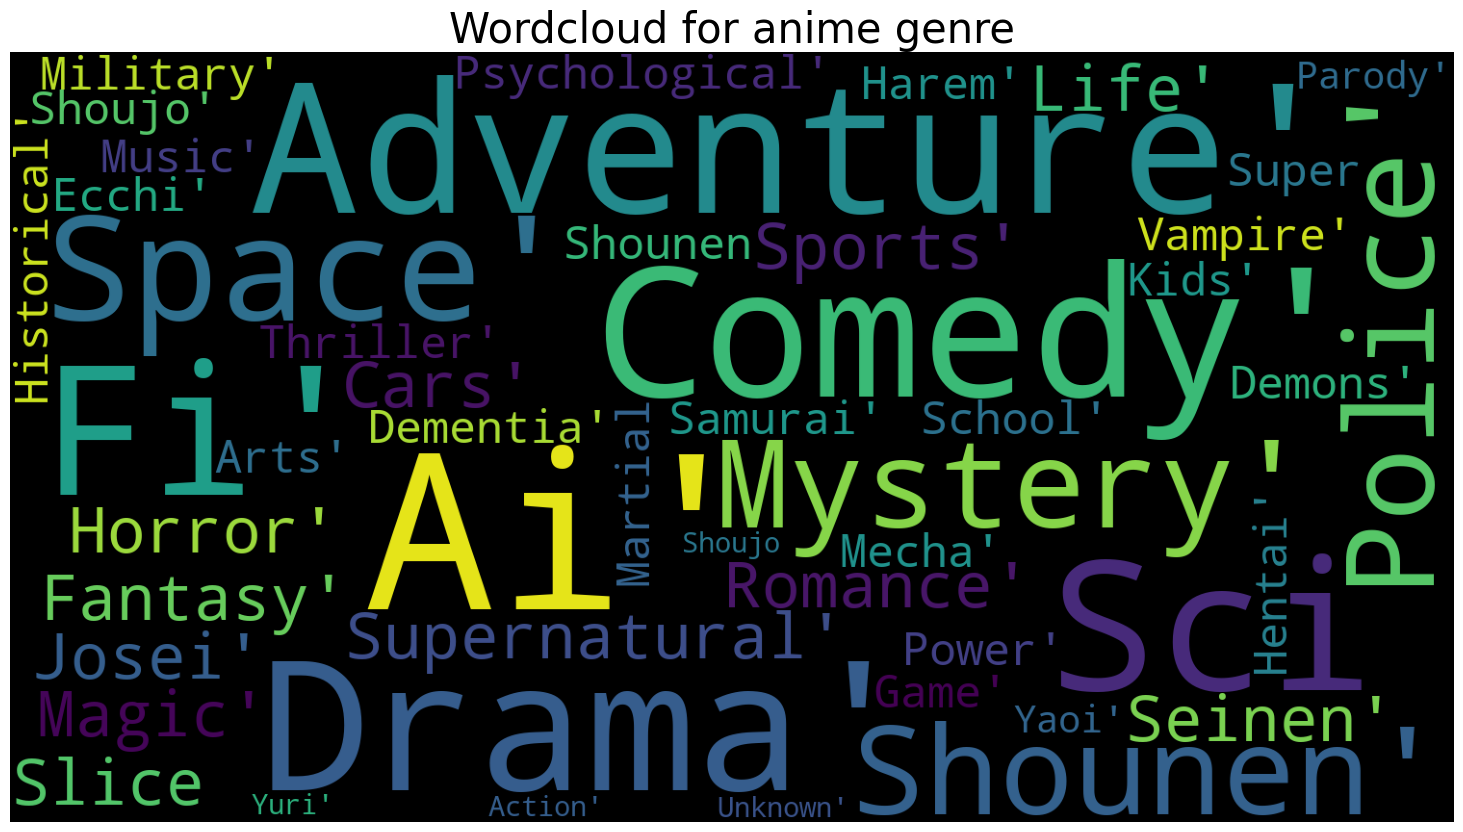

In [24]:
plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('Wordcloud for anime genre',fontsize=30)
plt.imshow(wordcloud_genre)

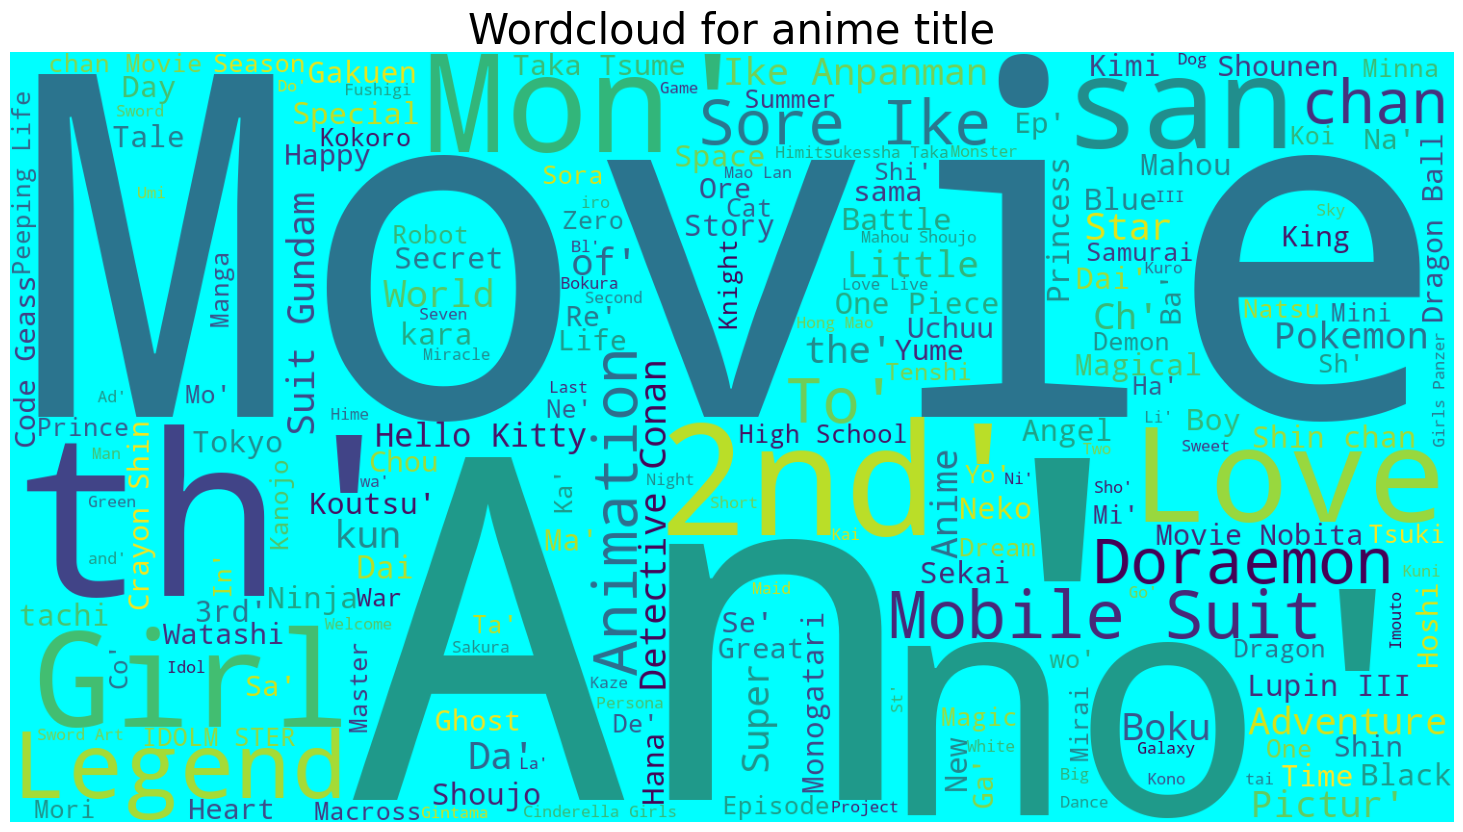

In [25]:
plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('Wordcloud for anime title',fontsize=30)
plt.imshow(wordcloud_title)

In [10]:
metadata.shape

(17562, 36)

In [11]:
metadata = metadata.drop_duplicates(subset='english_name', keep='first')
metadata.shape

(17367, 36)

# TF-IDF Implementation

In [67]:
import math
from collections import defaultdict, Counter
from sklearn.preprocessing import normalize
import re
from scipy.sparse import csr_matrix

class MyTfidfVectorizer:
    def __init__(self, min_df=1, max_df=1.0, ngram_range=(1, 1), stop_words=None, smooth_idf=True, norm='l2'):
        self.vocab = {}  
        self.idf_values = {}  
        self.min_df = min_df  
        self.max_df = max_df 
        self.ngram_range = ngram_range
        self.stop_words = stop_words if stop_words else set()
        self.smooth_idf = smooth_idf
        self.norm = norm

    def tokenize(self, document):
        tokens = re.findall(r'\b\w+\b', document.lower())
        ngrams = []
        for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
            ngrams.extend([' '.join(tokens[i:i + n]) for i in range(len(tokens) - n + 1)])
        return [ngram for ngram in ngrams if ngram not in self.stop_words]

    def fit(self, corpus):
        doc_freq = Counter()
        total_documents = len(corpus)
        vocab_set = set()
        for doc in corpus:
            words = set(self.tokenize(doc))
            vocab_set.update(words)
            doc_freq.update(words)
        self.vocab = {
            word: i for i, word in enumerate(
                word for word, count in doc_freq.items()
                if count >= self.min_df and count <= self.max_df * total_documents
            )
        }
        for term in self.vocab:
            num_documents_with_term = doc_freq[term]
            if self.smooth_idf:
                self.idf_values[term] = math.log((total_documents + 1) / (1 + num_documents_with_term)) + 1
            else:
                self.idf_values[term] = math.log(total_documents / num_documents_with_term) + 1
                
    def transform(self, corpus):
        rows, cols, data = [], [], []
        for row_idx, doc in enumerate(corpus):
            words = self.tokenize(doc)
            term_count = Counter(words)
            total_terms = len(words)
            for word, count in term_count.items():
                if word in self.vocab:
                    tf = count / total_terms
                    idf = self.idf_values[word]
                    tfidf_score = tf * idf 
                    rows.append(row_idx)
                    cols.append(self.vocab[word])
                    data.append(tfidf_score)
        tfidf_matrix = csr_matrix((data, (rows, cols)), shape=(len(corpus), len(self.vocab)))
        if self.norm:
            tfidf_matrix = normalize(tfidf_matrix, norm=self.norm, axis=1)
        return tfidf_matrix
        
    def fit_transform(self, corpus):
        self.fit(corpus)
        return self.transform(corpus)


In [13]:
metadata.columns

Index(['anime_id', 'title', 'score', 'genres', 'english_name', 'japanese_name',
       'type', 'episodes', 'aired', 'premiered', 'Producers', 'licensors',
       'studios', 'source', 'duration', 'rating', 'ranked', 'popularity',
       'members', 'favorites', 'watching', 'Completed', 'on_hold', 'dropped',
       'plan_to_watch', 'score_10', 'score_9', 'score_8', 'score_7', 'score_6',
       'score_5', 'score_4', 'score_3', 'score_2', 'score_1', 'description'],
      dtype='object')

In [24]:
vec = MyTfidfVectorizer()
tfidf_matrix=vec.fit_transform(metadata['genres'])

In [25]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [26]:
indices=pd.Series(metadata.index,index=metadata['english_name'])
titles=metadata['english_name']
def recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:8]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [31]:
recommendations('Death Note')

161                                Xenosaga The Animation
7845                                   Cheorin Samchongsa
1127                                         Spaceketeers
2782                                         Ninja Robots
4243    Super Bestial Machine God Dancougar:Blazing Ep...
4888                                       Ring of Gundam
7888    Mobile Suit Gundam Battlefield Record: Avant-T...
Name: english_name, dtype: object

In [41]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    num_relevant_at_k = sum([1 for item in recommended_k if item in relevant])
    return num_relevant_at_k / k

def mean_average_precision(recommended_lists, relevant_lists):
    average_precisions = []
    for recommended, relevant in zip(recommended_lists, relevant_lists):
        precisions = []
        num_hits = 0
        for i, rec in enumerate(recommended):
            if rec in relevant:
                num_hits += 1
                precisions.append(num_hits / (i + 1))  
        if precisions:
            average_precisions.append(np.mean(precisions))
        else:
            average_precisions.append(0)
    return np.mean(average_precisions)

def reciprocal_rank(recommended, relevant):
    for rank, item in enumerate(recommended, start=1):
        if item in relevant:
            return 1 / rank
    return 0

def mean_reciprocal_rank(recommendations_list, relevant_items_list):
    reciprocal_ranks = [
        reciprocal_rank(recommended, relevant)
        for recommended, relevant in zip(recommendations_list, relevant_items_list)
    ]
    return sum(reciprocal_ranks) / len(reciprocal_ranks)

recommended_lists = [
    ['Xenosaga The Animation', 'Cheorin Samchongsa', 'Spaceketeers'],
    ['Naruto:Shippuden', 'Boruto: Jump Festa 2016 Special', 'Flame of Recca'],
    ['The Sky Crawlers', 'Twilight of the Cockroaches', 'Future War Year 198X', 'Area 88']
] 
relevant_lists = [
    ['Xenosaga The Animation'],
    ['Naruto:Shippuden', 'Boruto: Jump Festa 2016 Special'],
    ['Future War Year 198X', 'Area 88']
]

map_score = mean_average_precision(recommended_lists, relevant_lists)
mrr_score = mean_reciprocal_rank(recommended_lists, relevant_lists)

print("MAP:", round(map_score, 2))
print("Mean Reciprocal Rank (MRR):", round(mrr_score, 2))

MAP: 0.81
Mean Reciprocal Rank (MRR): 0.78


In [74]:
metadata.to_csv('anime_recsys.csv', index=False)

In [20]:
import joblib

joblib.dump(tfidf_matrix, 'animevec_tfidf-description-based.joblib')

['animevec_tfidf-description-based.joblib']